# Text Mining -  Group Project

---

# Preparing the Data

In [3]:
import gensim
#import hdbscan
import nltk
import timeit
import numpy as np
import pandas as pd
import random
import re
import string
import umap

from sklearn.utils import shuffle
from nltk.tokenize import regexp_tokenize
from sklearn.model_selection import train_test_split

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Loading the Data

### Reddit News

In [12]:
import os
os.getcwd()

'C:\\Users\\dasha'

In [5]:
reddit_path = "data/reddit_worldnews.csv"
reddit_file = pd.read_csv(reddit_path, encoding="utf-8", encoding_errors="ignore")
print("reddit_file_clmns:", reddit_file.columns)
reddit = pd.DataFrame(reddit_file["title"]).rename(columns={"title":"Headline"})
reddit.head()

reddit_file_clmns: Index(['time_created', 'date_created', 'up_votes', 'down_votes', 'title',
       'over_18', 'author', 'subreddit'],
      dtype='object')


,Headline
0,Scores killed in Pakistan clashes
1,Japan resumes refuelling mission
2,US presses Egypt on Gaza border
3,Jump-start economy: Give health care to all
4,Council of Europe bashes EU&UN terror blacklist


### Ireland News

In [6]:
ireland_path = "data/ireland-news-headlines.csv"
ireland_file = pd.read_csv(ireland_path, encoding="utf-8", encoding_errors="ignore")
print("ireland_file_clmns:", ireland_file.columns)
ireland_filtered_date = ireland_file[(ireland_file["publish_date"] >= 20080125) & 
                                     (ireland_file["publish_date"] <= 20161122)]
ireland = pd.DataFrame(ireland_file["headline_text"]).rename(columns={"headline_text":"Headline"})
ireland.head()

ireland_file_clmns: Index(['publish_date', 'headline_category', 'headline_text'], dtype='object')


,Headline
0,UUP sees possibility of voting Major out
1,Pubs targeted as curbs on smoking are extended
2,Papers reveal secret links with O'Neill cabinet
3,Domestic chaos as Italy takes EU presidency
4,Learning about the star to which we owe life


In [16]:
type(ireland_file)

pandas.core.frame.DataFrame

## Preprocessing

In [7]:
# Pre-processing 
# Regular expression used for tokenization
pattern = r'''(?x)    
(?:[A-Z]\.)+          
|\w+(?:-\w+)*         
|\$?\d+(?:\.\d+)?%?   
|\.\.\.               
|[][.,;"\'?():-_`]  
'''

# Lemmatizer used 
lemmatizer = nltk.WordNetLemmatizer()

def preprocessing(df):
    """Input: dataframe
       Output: preprocessed dataframe"""
    
    # Reduce amount of data for quicker training purposes
    # Headline = df["Headline"].head(100)
        
    # Get the stopwords and punctuation
    stopwords = nltk.corpus.stopwords.words('english')
    punct = list(string.punctuation)
    
    # Initialize tokenized list of headlines
    # Get list of headlines
    headlns_lst = df["Headline"].to_list()
    
    tokenized_lines = []
    for headln in headlns_lst:
        line = str(headln).strip().lower()
        line = regexp_tokenize(line, pattern)
        line = [tok for tok in line if tok not in stopwords and tok not in punct and tok.isalpha() and len(tok)>2]
        tokenized_lines.append(line)
    
    # Initialize lemmatized list of headlines
    pp_df = pd.DataFrame(columns = ["Headline"])
    
    lemmatized_lines = [[lemmatizer.lemmatize(token) for token in headln] for headln in tokenized_lines]
    line_df = pd.DataFrame({"Headline": lemmatized_lines})
    pp_df = pp_df.append(line_df, ignore_index=True)
 
    return pp_df

### Reddit News

In [8]:
reddit_pp = preprocessing(reddit)
reddit_pp
t = timeit.timeit(lambda:reddit_pp)
print(t)
print(reddit_pp)

0.0545226999965962
                                                 Headline
0                        [score, killed, pakistan, clash]
1                    [japan, resume, refuelling, mission]
2                            [press, egypt, gaza, border]
3                           [economy, give, health, care]
4              [council, europe, bash, terror, blacklist]
...                                                   ...
509231  [heil, trump, donald, trump, white, nationalis...
509232    [people, speculating, could, madeleine, mccann]
509233     [professor, receives, arab, researcher, award]
509234  [nigel, farage, attack, response, trump, ambas...
509235  [palestinian, wielding, knife, shot, dead, wes...

[509236 rows x 1 columns]


C:\Users\dasha\AppData\Local\Temp\ipykernel_26428\2543675033.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pp_df = pp_df.append(line_df, ignore_index=True)


### Ireland News

In [9]:
ireland_pp = preprocessing(ireland)
ireland_pp

C:\Users\dasha\AppData\Local\Temp\ipykernel_26428\2543675033.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pp_df = pp_df.append(line_df, ignore_index=True)


,Headline
0,"[uup, see, possibility, voting, major]"
1,"[pub, targeted, curb, smoking, extended]"
2,"[paper, reveal, secret, link, neill, cabinet]"
3,"[domestic, chaos, italy, take, presidency]"
4,"[learning, star, owe, life]"
...,...
1611490,"[reserve, member, defence, force, allowed, ser..."
1611491,"[maureen, dowd, joe, biden, crazy, irish, plan..."
1611492,"[andy, murray, roll, back, year, centre, court]"
1611493,"[delta, variant, could, significant, damage, p..."


In [ ]:
# Need to use pre-trained embeddings since headlines not enough
# Should we cut out randomly some data of the ireland dataset so that we have equal amount or do we want to normalize in the
# end the amount of headlines per theme for the amount of data ?

# Sentence Embeddings

We are sentence embeddings by averaging the pre-trained word embeddings from the GoogleNews vectors. These embeddings can be found at https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g.

In [9]:
# The goal is to be able to read the GoogleNews from its URL but haven't found a simple way to read a 
# bin.gz file from URL yet. 
model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [64]:
def mean_vector(word2vec_model, doc):
    """Calculate the mean vector according to a word2vec model for one document/headline"""
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model]
    if len(doc) >= 1:
        return sum(word2vec_model[doc])/len(doc)
    else:
        return []

def doc_embeddings(dataset):
    """Calculate the mean vector for all documents in a dataset.
    Outputs a dataframe with document and 300 dim vector representation of it."""
    embeddings_df = pd.DataFrame()

    for doc in dataset["Headline"]:
        vec = mean_vector(model, doc)
        if len(vec) > 0:
            vec_df = pd.Series(vec)
            doc_df = pd.Series([doc]).append(vec_df, ignore_index = True)
            embeddings_df = embeddings_df.append(doc_df, ignore_index=True) 
    
    return embeddings_df

In [ ]:
# Use all the data, not just first 1000 headlines when finalizing process.
reddit_embed = doc_embeddings(reddit_pp)
reddit_embed

In [66]:
ireland_embed = doc_embeddings(ireland_pp)
ireland_embed

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,"[uup, see, possibility, voting, major]",-0.019440,0.096291,0.004242,0.111938,-0.122192,0.011169,0.063950,-0.051147,0.126831,...,-0.105103,-0.063385,-0.040253,-0.077667,0.060120,-0.015381,-0.030247,-0.026241,0.083755,-0.034698
1,"[pub, targeted, curb, smoking, extended]",-0.083624,0.037817,-0.006555,0.198828,-0.109766,-0.000049,-0.002713,-0.003613,0.247559,...,0.015234,0.042723,-0.034412,0.052075,-0.091187,0.059448,0.062207,0.046216,0.077539,-0.031396
2,"[paper, reveal, secret, link, neill, cabinet]",-0.109766,0.024805,-0.097681,-0.043976,-0.031348,0.067725,0.056592,-0.013770,0.245703,...,-0.072803,0.006732,-0.129858,0.046387,-0.097412,-0.167065,0.065753,-0.116599,-0.008594,0.048206
3,"[domestic, chaos, italy, take, presidency]",-0.069678,0.009131,0.003613,0.110767,-0.011865,-0.110742,0.000977,-0.161548,0.070337,...,-0.104053,-0.004004,-0.069653,0.019873,-0.081329,0.116309,-0.025882,-0.066553,0.028613,0.098199
4,"[learning, star, owe, life]",0.045166,0.118469,0.081787,0.070648,0.093658,0.063385,0.142822,-0.122314,0.066040,...,-0.059326,0.094330,-0.176895,-0.117706,-0.069595,-0.030823,0.028152,0.034851,-0.002686,0.005997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,"[decisive, loss]",0.072021,0.074402,0.037495,-0.089233,0.029663,-0.036621,-0.067627,-0.306641,0.217285,...,0.001862,-0.014404,0.019531,-0.077393,-0.056885,0.110840,-0.101562,-0.075928,-0.063599,0.069092
94,"[meaty, food]",-0.113281,0.130859,-0.164062,0.199097,-0.008545,0.028320,0.063965,-0.101440,-0.188965,...,-0.204590,-0.239502,-0.059875,0.279297,0.058777,0.008423,0.044922,0.039307,0.031982,0.100235
95,"[terminal, opportunism]",0.250977,0.082642,-0.138916,0.208008,-0.098938,-0.235352,-0.096924,-0.029846,0.259766,...,-0.155945,-0.179688,-0.023926,0.000244,-0.083679,-0.063477,0.019531,0.001221,-0.126709,0.212280
96,"[surprised, scribe]",0.082886,0.087036,0.039307,-0.024536,0.002625,0.089111,0.089844,0.116455,0.133461,...,0.100708,-0.163574,0.015137,0.006470,-0.064697,-0.154785,-0.206543,-0.067993,-0.052246,0.055420


In [71]:
ireland_embed.loc[:, 1:].to_numpy()

array([[-0.0194397 ,  0.09629059,  0.00424194, ..., -0.0262413 ,
         0.08375549, -0.03469849],
       [-0.08362427,  0.03781738, -0.00655518, ...,  0.04621582,
         0.07753906, -0.03139649],
       [-0.10976563,  0.02480469, -0.09768067, ..., -0.11659851,
        -0.00859375,  0.04820557],
       ...,
       [ 0.25097656,  0.0826416 , -0.13891602, ...,  0.0012207 ,
        -0.12670898,  0.21228027],
       [ 0.08288574,  0.08703613,  0.03930664, ..., -0.06799316,
        -0.05224609,  0.05541992],
       [ 0.35546875,  0.18359375,  0.14941406, ...,  0.04980469,
        -0.22265625,  0.00405884]])

---

# Clustering

In [131]:
def generate_clusters(sentence_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      random_state = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """
    
    umap_embeddings = umap.UMAP(n_neighbors=n_neighbors, 
                                n_components=n_components, 
                                metric='cosine', 
                                random_state=random_state).fit_transform(sentence_embeddings.loc[:, 1:].to_numpy())

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean', 
                               cluster_selection_method='eom').fit(umap_embeddings)
    

    return clusters


def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given cluster supplied from running hdbscan
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost


def random_search(embeddings, space, num_evals):
    """
    Randomly search hyperparameter space and limited number of times 
    and return a summary of the results
    """
    
    results = []
    
    for i in range(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        
        clusters = generate_clusters(embeddings, 
                                     n_neighbors = n_neighbors, 
                                     n_components = n_components, 
                                     min_cluster_size = min_cluster_size, 
                                     random_state = 42)
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, 
                        label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [132]:
space = {"n_neighbors": range(5,15),
        "n_components": range(2,7),
        "min_cluster_size": range(2,15),
        "random_state": 42}

random_search(embeddings=reddit_embed, space=space, num_evals= 100)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
78,78,7,3,9,2,0.000000
45,45,7,4,10,3,0.001001
22,22,7,4,11,3,0.001001
16,16,7,2,10,3,0.003003
83,83,6,4,8,3,0.008008
...,...,...,...,...,...,...
35,35,9,4,13,15,0.574575
63,63,7,3,14,14,0.583584
10,10,11,3,13,15,0.605606
57,57,13,3,14,12,0.627628


In [126]:
reddit_clusters = generate_clusters(sentence_embeddings= reddit_embed, n_neighbors= 3, n_components=3, min_cluster_size=3, random_state=42)

## Latent Dirichlet Analysis
Gensim Implementation

## Reddit

In [10]:
#Exploring vocabulary size
all_words = [word for tokens in reddit_pp['Headline'] for word in tokens]
headline_lengths = [len(tokens) for tokens in reddit_pp['Headline']]

vocab = sorted(list(set(all_words)))

print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max headline length is {}'.format(max(headline_lengths)))

4816959 words total, with a vocabulary size of 73363
Max headline length is 38


In [12]:
#Dictionary representation. Each word in the headline corpus a unique integer identifier.
reddit_dict = gensim.corpora.Dictionary(reddit_pp.Headline)

#view integer mappings
reddit_dict.token2id

{'clash': 0,
 'killed': 1,
 'pakistan': 2,
 'score': 3,
 'japan': 4,
 'mission': 5,
 'refuelling': 6,
 'resume': 7,
 'border': 8,
 'egypt': 9,
 'gaza': 10,
 'press': 11,
 'care': 12,
 'economy': 13,
 'give': 14,
 'health': 15,
 'bash': 16,
 'blacklist': 17,
 'council': 18,
 'europe': 19,
 'terror': 20,
 'bale': 21,
 'behind': 22,
 'castle': 23,
 'farmer': 24,
 'hay': 25,
 'hide': 26,
 'illegal': 27,
 'presto': 28,
 'tried': 29,
 'unveils': 30,
 'gridlock': 31,
 'protest': 32,
 'strike': 33,
 'mismanagement': 34,
 'program': 35,
 'nicolas': 36,
 'ryanair': 37,
 'sarkozy': 38,
 'sue': 39,
 'threatens': 40,
 'met': 41,
 'missile': 42,
 'plan': 43,
 'polish': 44,
 'resistance': 45,
 'shield': 46,
 'town': 47,
 'video': 48,
 'archbishop': 49,
 'call': 50,
 'canterbury': 51,
 'cruel': 52,
 'law': 53,
 'new': 54,
 'online': 55,
 'punish': 56,
 'thoughtless': 57,
 'time': 58,
 'word': 59,
 'cleansing': 60,
 'envoy': 61,
 'ethnic': 62,
 'kenya': 63,
 'top': 64,
 'violence': 65,
 'building': 66,

In [13]:
#Bag of Words - counts how many times a word token occurs within a headline
#Output contains a vector for each headline, in the form of (word id, frequency of word occurrence in a headline).

reddit_BOW = [reddit_dict.doc2bow(headline) for headline in reddit_pp['Headline']]

In [16]:
#LDA - first attempt
#As a starting point, I’ve fit a model with 5 topics and 10 passes.

from gensim.models.ldamodel import LdaModel

k = 5
reddit_lda = LdaModel(reddit_BOW,
                      num_topics = k,
                      id2word = reddit_dict,
                      random_state = 1,
                      passes=10)

reddit_lda.show_topics()

[(0,
  '0.024*"attack" + 0.017*"killed" + 0.016*"isi" + 0.013*"police" + 0.012*"state" + 0.011*"kill" + 0.010*"pakistan" + 0.010*"force" + 0.009*"strike" + 0.009*"islamic"'),
 (1,
  '0.011*"say" + 0.010*"israel" + 0.009*"migrant" + 0.009*"right" + 0.008*"year" + 0.007*"human" + 0.007*"israeli" + 0.007*"said" + 0.006*"palestinian" + 0.006*"month"'),
 (2,
  '0.024*"russia" + 0.022*"syria" + 0.018*"president" + 0.016*"russian" + 0.013*"say" + 0.013*"syrian" + 0.010*"turkey" + 0.009*"protest" + 0.009*"war" + 0.009*"aleppo"'),
 (3,
  '0.032*"china" + 0.013*"new" + 0.010*"world" + 0.009*"japan" + 0.008*"brexit" + 0.008*"sea" + 0.008*"india" + 0.007*"first" + 0.007*"nuclear" + 0.007*"deal"'),
 (4,
  '0.018*"news" + 0.018*"south" + 0.015*"korea" + 0.013*"north" + 0.012*"bbc" + 0.010*"saudi" + 0.010*"refugee" + 0.009*"court" + 0.007*"woman" + 0.007*"say"')]

## PyLDAvis
A library is a great way to visualize topics from a topic model.

In [17]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(reddit_lda, reddit_BOW, dictionary = reddit_lda.id2word)
vis

C:\Users\dasha\AppData\Local\Programs\Python\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
C:\Users\dasha\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.236226 -0.057648       1        1  21.898463
1     -0.090623  0.030904       2        1  20.015329
2     -0.002626 -0.288006       3        1  19.550895
0      0.362113 -0.003294       4        1  19.337960
4     -0.032639  0.318045       5        1  19.197353, topic_info=           Term          Freq         Total Category  logprob  loglift
280       china  33484.000000  33484.000000  Default  30.0000  30.0000
239      russia  22981.000000  22981.000000  Default  29.0000  29.0000
486      attack  22267.000000  22267.000000  Default  28.0000  28.0000
3837      syria  20345.000000  20345.000000  Default  27.0000  27.0000
1064  president  17110.000000  17110.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
20       terror   3424.702694   5322.241354   Topic5  -5.5985   1.2095
508         ban   3620.658166   7370.111303   Topic5  -5.5428   0.9396
121     germany   3653.160203   7899.123828   Topic5  -5.5339   0.8792
182       child   3686.521738  10086.569424   Topic5  -5.5248   0.6439
42      missile   3341.769944   6239.764928   Topic5  -5.6230   1.0260

[256 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
3684       1  0.999621    according
2016       2  0.999887     activist
1792       4  0.999892       afghan
139        4  0.999832  afghanistan
924        5  0.999732       africa
...      ...       ...          ...
5723       3  0.999782        yemen
64861      1  0.000369         zika
64861      2  0.997686         zika
64861      3  0.000369         zika
64861      5  0.001845         zika

[293 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1, 5])

## Word Cloud

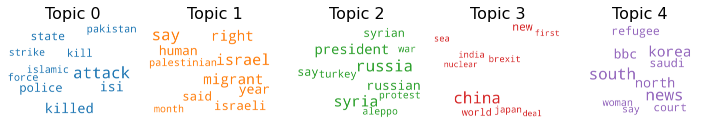

In [18]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = reddit_lda.show_topics(formatted=False)

fig, axes = plt.subplots(1, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

---

## Ireland

In [19]:
#Exploring vocabulary size
all_words = [word for tokens in ireland_pp['Headline'] for word in tokens]
headline_lengths = [len(tokens) for tokens in ireland_pp['Headline']]

vocab = sorted(list(set(all_words)))

print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max headline length is {}'.format(max(headline_lengths)))

8034604 words total, with a vocabulary size of 98859
Max headline length is 28


In [20]:
#Dictionary representation. Each word in the tweet corpus a unique integer identifier.
ireland_dict = gensim.corpora.Dictionary(ireland_pp.Headline)

#View integer mappings
ireland_dict.token2id

{'major': 0,
 'possibility': 1,
 'see': 2,
 'uup': 3,
 'voting': 4,
 'curb': 5,
 'extended': 6,
 'pub': 7,
 'smoking': 8,
 'targeted': 9,
 'cabinet': 10,
 'link': 11,
 'neill': 12,
 'paper': 13,
 'reveal': 14,
 'secret': 15,
 'chaos': 16,
 'domestic': 17,
 'italy': 18,
 'presidency': 19,
 'take': 20,
 'learning': 21,
 'life': 22,
 'owe': 23,
 'star': 24,
 'card': 25,
 'detail': 26,
 'education': 27,
 'proposal': 28,
 'skill': 29,
 'asked': 30,
 'authority': 31,
 'concrete': 32,
 'road': 33,
 'switch': 34,
 'use': 35,
 'cancel': 36,
 'course': 37,
 'evening': 38,
 'intake': 39,
 'ucd': 40,
 'day': 41,
 'longer': 42,
 'second': 43,
 'future': 44,
 'hand': 45,
 'john': 46,
 'lie': 47,
 'may': 48,
 'unionist': 49,
 'cold': 50,
 'dead': 51,
 'found': 52,
 'high': 53,
 'hillside': 54,
 'school': 55,
 'student': 56,
 'affect': 57,
 'cardinal': 58,
 'difficult': 59,
 'let': 60,
 'peace': 61,
 'process': 62,
 'tell': 63,
 'defection': 64,
 'fear': 65,
 'mayhew': 66,
 'soothes': 67,
 'tory': 68,

In [22]:
#Bag of Words - counts how many times a word token occurs within a tweet
#Output contains a vector for each tweet, in the form of (word id, frequency of word occurrence in tweet).

ireland_BOW = [ireland_dict.doc2bow(headline) for headline in ireland_pp['Headline']]

In [ ]:
#LDA - first attempt
#I’ve fit a model with 5 topics and 10 passes.

from gensim.models.ldamodel import LdaModel

k = 5
ireland_lda = LdaModel(ireland_BOW,
                      num_topics = k,
                      id2word = ireland_dict,
                      random_state = 1,
                      passes=10)

ireland_lda.show_topics()

---

## PyLDAvis
A library is a great way to visualize topics from a topic model.

In [81]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(ireland_lda, ireland_BOW, dictionary = ireland_lda.id2word)
vis

C:\Users\dasha\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.083078 -0.132387       1        1  22.415058
0      0.424648  0.054539       2        1  21.010979
4     -0.143621  0.169431       3        1  20.104377
2     -0.065445 -0.327474       4        1  18.930174
1     -0.132503  0.235890       5        1  17.539412, topic_info=          Term          Freq         Total Category  logprob  loglift
154      irish  68826.000000  68826.000000  Default  30.0000  30.0000
166     dublin  44626.000000  44626.000000  Default  29.0000  29.0000
83         man  31253.000000  31253.000000  Default  28.0000  28.0000
96       woman  23277.000000  23277.000000  Default  27.0000  27.0000
929       time  33772.000000  33772.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
216    service   5681.426326   9337.342436   Topic5  -5.5014   1.2439
206        new   8519.529210  49285.639252   Topic5  -5.0963  -0.0146
33628    biden   5165.262377   7660.718409   Topic5  -5.5967   1.3466
214        get   5021.831874  17506.212934   Topic5  -5.6248   0.4920
276        one   4836.878066  14919.476578   Topic5  -5.6623   0.6143

[232 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3095      4  0.999892      air
3981      3  0.999954     amid
2159      1  0.999822  another
1050      5  0.999951     baby
232       1  0.315047     back
...     ...       ...      ...
96        2  0.999986    woman
651       4  0.999828   worker
782       1  0.999954    world
199       1  0.315957     year
199       2  0.684019     year

[248 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 3, 2])

## Word Cloud

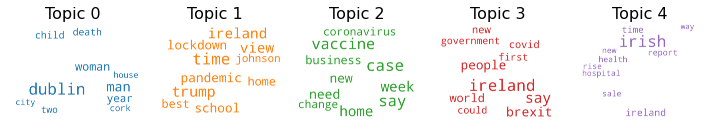

In [95]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ireland_lda.show_topics(formatted=False)

fig, axes = plt.subplots(1, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

---

---